# Tarini's Gekko test for solving OCT

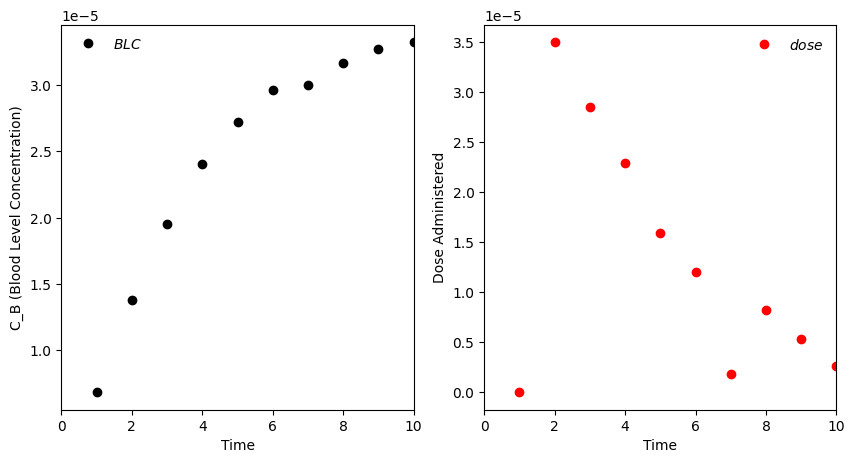

In [51]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector (22 days)
nt= 10
m.time = np.array([i for i in range(1, nt+1)]) 

# State Variables and Parameters
C_B = m.Var(value=6.8e-6)  # Blood concentration in mg/L

#C_target = m.Var() # Blood level concentration in mg/L for SOC / target
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
dose = m.Var()  # Drug administered at time t
#D_total = m.Var() # Total drug in body by time t
RC = m.Var(value=0) # Running cost (the integrand of the objective function)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Patient-specific parameters
V_max = 3.5e-12  # Maximum rate (pmol/min/pmol P450)
K_m = 16e-6  # Substrate concentration at half-maximal rate (mol/L)

# Equations 
BV = 5.0  # units: L
m.Equation(C_B.dt() == (dose - M) / BV)  # Rate of change of blood concentration
m.Equation(M.dt() == (V_max * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
#m.Equation(D_total.dt() == 5)  # Rate of change of total dose 
m.Equation(RC.dt() == -(3.0*(C_B**2) + dose**2)) # Integrand of cost functional 
m.Obj(RC*final) # Objective function

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e6
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=False) # solve

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()
axes[0].plot(m.time, C_B.value,'ko',label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0,nt))

axes[1].plot(m.time, dose.value,'ro',label=r'$dose$')
axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0,nt))
plt.show()

apm 128.62.96.33_gk_model77 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            9
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:            900
 Number of total equations: -          800
 Number of slack variables: -          100
 ---------------------------------------
 Degrees of freedom       :              0
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.22847E+04  3.00000E+01
    1 -1.78428E+03  7.73956E-01
    2 -3.47319E+03  9.60340E-02
    3 -6.589

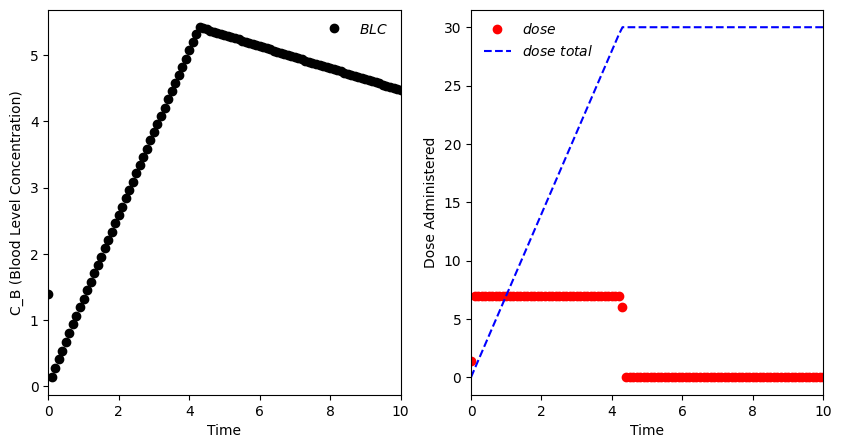

In [112]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
t_max = 10 # each cycle is ~7 days
t_step = 0.1
m.time = np.arange(0, t_max + t_step, t_step)

# State Variables and Parameters
C_B = m.Var(value=1.4, lb=0.0)  # Blood concentration in mg/L
C_B_target = m.Param(value=np.full(len(m.time), 1.0)) # After preliminary implementation, I would load this in
#C_target = m.Var() # Blood level concentration in mg/L for SOC / target
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
dose = m.Var(value=1.4, lb=0.0, ub=7)  # Drug administered at time t
D_tot = m.Var(value=0.0) # Total drug in body by time t
RC = m.Var(value=0.0) # Running cost (the integrand of the objective function)

# What time point do we want to minimize at?
p = np.zeros(len(m.time))  # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Set constraints
mask = np.zeros(len(m.time))
mask[0] = 1.0
first_point = m.Param(value=mask)
#m.Equation(dose * first_point >= 0.0)  # ensure nonzero first dose
#m.Equation(C_B * first_point == (dose * first_point) / BV) # ensure nonzero first BLC
m.Equation(D_tot <= 30) # total dose cannot go over  this 

# Patient-specific parameters
V_max = 1.0  # Maximum rate (pmol/min/pmol P450)
K_m = 1.0  # Substrate concentration at half-maximal rate (mol/L)
BSA = 1.0

# Equations 
BV = 5.0  # units: L
m.Equation(D_tot.dt() == dose)  # Rate of change of total dose 
m.Equation(C_B == (D_tot * BSA - M) / BV)  # Rate of change of blood concentration
m.Equation(M.dt() == (V_max * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
m.Equation(RC.dt() == -(3.0*((C_B-C_B_target)**2) + dose**2)) # Integrand of cost functional 
m.Obj(RC) # Objective function

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e9
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=True) # solve

# Plot everything
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()

# Plot C_B (Blood Level Concentration)
axes[0].plot(m.time, C_B.value, 'ko', label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0, t_max))

# Plot Dose and D_tot
axes[1].plot(m.time, dose.value, 'ro', label=r'$dose$')
axes[1].plot(m.time, D_tot.value, 'b--', label=r'$dose\ total$')
axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0, t_max))

plt.show()


apm 128.62.96.33_gk_model90 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           52
   Intermediates:            0
   Connections  :            0
   Equations    :           19
   Residuals    :           19
 
 Number of state variables:            530
 Number of total equations: -          210
 Number of slack variables: -          130
 ---------------------------------------
 Degrees of freedom       :            190
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.08 NLPi:    9 Dpth:    0 Lvs:    3 Obj: -7.02E+02 Gap:       NaN
Iter:     2 I: -1 Tm:      0.06 NLPi:    1 Dpth:

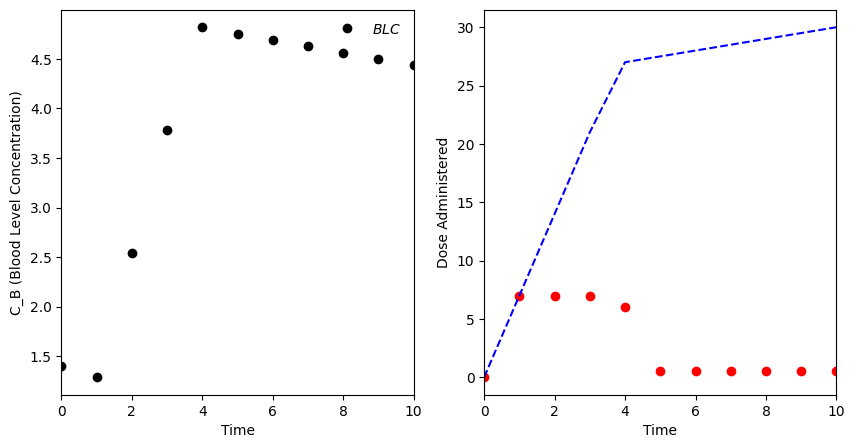

In [139]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
t_max = 10  # each cycle is ~7 days
t_step = 1.0
m.time = np.arange(0, t_max + t_step, t_step)

# Step 1: Create dose array with a maximum dose of 7
dose_max = 7.0
dose = m.Array(m.Var, len(m.time))  # Create array of dose variables

for i in range(len(dose)):
    dose[i].value = 0.0
    dose[i].lower = 0.0
    dose[i].upper = dose_max

# Step 2: Create binary control variables u[i] to limit the number of doses
u = m.Array(m.Var, len(m.time))  # Binary variables for control (0 or 1)
for i in range(len(u)):
    u[i] = m.Var(integer=True)
    u[i].value = 0.0 # Initialize all u[i] to 0 (no dose)
    u[i].lower = 0.0 # Lower bound (0 means no dose)
    u[i].upper = 1.0 # Upper bound (1 means dose delivered)

u[0].value = 1.0  # make sure we always deliver dose on the first day

# Constraint : limit dose to a maximum of 5 doses
m.Equation(np.sum(u) == 5)  # Sum of u[i] must be exactly 5 doses

# Step 3: Create constraint to limit dose to a maximum of 5 times
for i in range(len(m.time)):
    m.Equation(dose[i] <= u[i] * dose_max)  # Dose must be <= dose_max when u[i] is 1

# Step 4: Create constraint to ensure the first dose is nonzero
mask = np.zeros(len(m.time))
mask[0] = 1.0  # First point is nonzero
first_point = m.Param(value=mask)
m.Equation(dose[0] >= 0.5)  # Ensure first dose is nonzero

# Step 5: Add the total dose constraint
D_tot = m.Var(value=0.0)  # Total drug in body by time t
m.Equation(D_tot.dt() == dose[0])  # First time step's dose is added to total dose
m.Equation(D_tot <= 30) # total dose cannot go over  this 

# Step 6: Define other variables and parameters
C_B = m.Var(value=1.4, lb=0.0)  # Blood concentration in mg/L
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
RC = m.Var(value=0.0)  # Running cost (the integrand of the objective function)

# Important parameters
BV = 5.0  # units: L
V_max = 1.0  # Maximum rate (pmol/min/pmol P450)
K_m = 1.0  # Substrate concentration at half-maximal rate (mol/L)
BSA = 1.0

# Step 7: Define the equations
m.Equation(C_B == (D_tot * BSA - M) / BV)  # Blood concentration of vincristine
m.Equation(M.dt() == (V_max * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
m.Equation(RC.dt() == -(3.0*((C_B)**2) + dose[0]**2)) # Integrand of cost functional 

# Set the objective function to minimize the total cost
p = np.zeros(len(m.time))  # mark final time point
p[-1] = 1.0
final = m.Param(value=p)
m.Obj(RC * final)

# Step 8: Solve the optimization problem
m.options.IMODE = 6  # optimal control mode
m.options.MAX_ITER = 1e6
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=True)  # solve

# Step 9: Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()

# Plot C_B (Blood Level Concentration)
axes[0].plot(m.time, C_B.value, 'ko', label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0, t_max))

# Plot Dose and D_tot
#[dose[i].value for i in range(len(m.time))]
axes[1].plot(m.time, dose[0].value, 'ro', label=r'$dose$')
axes[1].plot(m.time, D_tot.value, 'b--', label=r'$dose\ total$')

# Only set the legend once for all plots
#axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0, t_max))

plt.show()


In [107]:
print(u)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
 [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


0.0